# 0. Importing Necessary Packages

In [1]:
# Printing the information of Python, IPython, OS, and the generation date.
# Before running this, you have to install version_information module with "pip install version_information".
%load_ext version_information
%version_information

Software versions
Python 3.7.9 64bit [GCC 7.3.0]
IPython 7.16.1
OS Linux 5.8.18 100.fc31.x86_64 x86_64 with fedora 31 Thirty_One
Mon May 02 10:40:24 2022 KST

In [2]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'pandas', 'astropy', 'photutils']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.21.0
matplotlib: ver 3.2.2
pandas: ver 1.2.4
astropy: ver 4.2.1
photutils: ver 1.0.2


In [3]:
# Matplotlib backend
%matplotlib notebook

# Importing necessary modules
import time
import numpy as np
import glob, os, copy
from matplotlib import pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
# from matplotlib.patches import Ellipse as ell

# 1. Displaying the Images

### 1) Image names

In [4]:
dir_img = "Combined_images/"
imglist = [dir_img+"M105-g.fits", dir_img+"M105-i.fits",
           dir_img+"M100-g.fits", dir_img+"M100-i.fits"]
n_img = len(imglist)
imglist

['Combined_images/M105-g.fits',
 'Combined_images/M105-i.fits',
 'Combined_images/M100-g.fits',
 'Combined_images/M100-i.fits']

### 2) Running DS9

In [5]:
# You can also run this command in terminal.
ds9_options = "-scalemode zscale -scale lock yes -frame lock image "
names = ""
for i in np.arange(n_img):
    names += imglist[i]+" "
ds9_command = "ds9 "+ds9_options+names+"&"
print('Running "'+ds9_command+'" in the terminal...')
os.system(ds9_command)

Running "ds9 -scalemode zscale -scale lock yes -frame lock image Combined_images/M105-g.fits Combined_images/M105-i.fits Combined_images/M100-g.fits Combined_images/M100-i.fits &" in the terminal...


0

# 2. Running Photutils Task 

### 1) Parameter Information of Photutils/Ellipse Task

#### Reference Link: [Elliptical Isophote Analysis](https://photutils.readthedocs.io/en/stable/isophote.html), [API for EllipseGeometry](https://photutils.readthedocs.io/en/stable/api/photutils.isophote.EllipseGeometry.html), and [API for Ellipse](https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Ellipse.html)

In [6]:
from photutils.isophote import EllipseGeometry, Ellipse
from photutils.isophote import build_ellipse_model

### 2) Declaration of Function (for convenience!)

In [7]:
def fit_ellipse(input_image,
                model_image=None, residual_image=None, display=False,
                x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,
                minsma=0.0, maxsma=50.0, step=1.0, linear=False,
                minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,
                sclip=3.0, nclip=0,
                mag0=25.0, refer=1.0, zerolevel=0.0,
                backgr=0.0):

    '''
    # --- basic input parameters --- #
    input_image - input image name ('[FILENAME].fits')
    model_image - output model image (default: '[FILENAME]_mod.fits')
    residual_image - output residual image (default: '[FILENAME]_res.fits')
    display - display the results or not? (boolean, default: False)
    
    # --- geompar set --- #
    x0, y0 - initial isophote center X, Y [pixel]
    ellip0, pa0 - initial ellipticity, position angle [degree]
    sma0 - initial semi-major axis (SMA) length [pixel]
    minsma - minimum SMA length for fitting [pixel] (default: 0.0)
    maxsma - maximum SMA length for fitting [pixel]
    step - SMA step between successive ellipses [pixel OR relative value]
    linear - linear SMA step for fitting? (boolean, default: False)
    
    # --- controlpar set --- #
    minit - minimum iteration number at each step of SMA (default: 10)
    maxit - maximum iteration number at each step of SMA (default: 100)
    hcenter - do you want to hold center fixed? (boolean, default: False)
    hellip - do you want to hold ellipticity fixed? (boolean, default: False)
    hpa - do you want to hold position angle fixed? (boolean, default: False)
    
    # --- samplepar set --- #
    sclip - sigma-clip criterion (default: 3)
    nclip - iteration number for the sigma clipping (default: 0)
    
    # --- magpar set --- #
    mag0 - magnitude zeropoint for sky brightness (default: 25.0)
    refer - reference count for sky brightness (default: 1.0)
    zerolevel - bias level (default: 0.0)    
    ### mag = mag0-2.5*log10((intensity-zerolevel)/refer)
    
    # --- bmodel parameter set --- #
    backgr - background level for making model image (default: 0.0)
    '''
    
    imgdata = fits.getdata(input_image, ext=0)    # If you use multi-extension images, you should revise this.
    iname = input_image.split('.fits')[0].split('/')[-1]    # Image name
    if (model_image is None):
        model_image = iname+'_mod2.fits'    # Output model image name
    if (residual_image is None):
        residual_image = iname+'_res2.fits'    # Output residual image name

    # Running Photutils/ellipse task
    g = EllipseGeometry(x0-1, y0-1, sma0, ellip0, pa0*np.pi/180., astep=step, linear_growth=linear,
                        fix_center=hcenter, fix_pa=hpa, fix_eps=hellip)
    ellipse = Ellipse(imgdata, geometry=g)
    
    kwargs = {"sma0":sma0, "minsma":minsma, "maxsma":maxsma, "step":step, "conver":0.05,
              "minit":minit, "maxit":maxit, "fflag":0.7, "maxgerr":0.5, "sclip":sclip, "nclip":nclip,
              "integrmode":"bilinear", "linear":linear, "maxrit":maxsma,
              "fix_center":hcenter, "fix_pa":hpa, "fix_eps":hellip}
    isolist = ellipse.fit_image(**kwargs)
    iso_tbl = isolist.to_table()
    iso_df  = iso_tbl.to_pandas()
    
    # Making model, residual images
    model = build_ellipse_model(imgdata.shape, isolist, fill=backgr)
    residual = imgdata - model
    fits.writeto(model_image, model, overwrite=True)
    fits.writeto(residual_image, residual, overwrite=True)

    if display:    # if display == True, DS9 will display input, model, and residual images.
        opt = " -scalemode zscale -scale lock yes -frame lock image "
        opt += " -tile grid mode manual -tile grid layout 3 1 "
        os.system("ds9 "+opt+input_image+" "+model_image+" "+residual_image+"&")

    return iso_df

### 4) Sky Estimation (depending on your image)

In [8]:
# ----- SDSS pixel scale & Magnitude zeropoint ----- #
pixel_scale = 0.396    # arcsec/pixel (SDSS image)
mag0_g = 23.85   # SDSS g-magnitude zeropoint for sky brightness (just for example)
# mag0_g = 21.84 + 2.5*np.log10(pixel_scale**(-2))  # mag/arcsec^2 --> mag/pixel^2
mag0_i = 22.17    # SDSS i-magnitude zeropoint for sky brightness (just for example)
# mag0_i = 20.16 + 2.5*np.log10(pixel_scale**(-2))  # mag/arcsec^2 --> mag/pixel^2
### You should revise these depending on your images! (Maybe) the above magnitude zeropoint is not so accurate... 
### https://www.sdss.org/dr14/imaging/other_info/

#### For magnitude zeropoint, please use the given value on the website below.

* **SDSS: [SDSS Imaging Information](https://www.sdss.org/dr14/imaging/other_info/)**
* **HST: [HST ACS Zeropoint](https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints)**

#### Or you can also measure the zeropoint by yourself using (secondary) calibration in your image.

#### Pixel scale is for tranforming the unit of surface brightness from ${\rm mag/pixel^2}$ to ${\rm mag/arcsec^2}$ (or the opposite).

#### If you just want to use ${\rm mag/pixel^2}$ unit, you do not have to use pixel scale of the images.

#### However, ${\rm mag/arcsec^2}$ unit is generally used for surface photometry.

In [9]:
# For g-band image of M105
imgname = "Combined_images/M105-g.fits"
x_center, y_center = 455.0, 455.0    # depending on your object & image size
r0 = 420.0    # outer boundary for sky estimation (up to you)

# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = 3.0*med - 2.0*avg, std
print("Image: "+imgname)
print("sky level: {0:.4f}".format(sky_val))
print("sky sigma: {0:.4f}".format(sky_sig))
# ---------- #

Image: Combined_images/M105-g.fits
sky level: 0.0202
sky sigma: 0.0154


### 5) Running Photutils/Ellipse Task & Showing the Results

In [10]:
sky_val_g = sky_val    # sky brightness (unit: pixel count)
rmax = 470.0    # maximum SMA (up to you)
kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.05, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.05,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":2, "mag0":mag0_g, "refer":sky_val_g,    # https://www.sdss.org/dr12/algorithms/magnitudes/
          "backgr":sky_val_g}  # Here you can change input (default) parameter if needed!
iso_df_g = fit_ellipse(imgname, display=True, **kwargs)

# def fit_ellipse(input_image, #output_table=None, interactive=False,
#                 model_image=None, residual_image=None, display=False, #data_file=None,
#                 x0=100.0, y0=100.0, ellip0=0.1, pa0=45.0, sma0=10.0,  # geompar
#                 minsma=0.0, maxsma=50.0, step=1.0, linear=False, #recenter=False,  # geompar
#                 minit=10, maxit=100, hcenter=False, hellip=False, hpa=False,  # controlpar
#                 sclip=3.0, nclip=0,  # samplepar
#                 mag0=25.0, refer=1.0, zerolevel=0.0,  # magpar
#                 backgr=0.0):#, interp='linear'):  # bmodel

In [11]:
# Columns in the result array
iso_df_g.columns

Index(['sma', 'intens', 'intens_err', 'ellipticity', 'ellipticity_err', 'pa',
       'pa_err', 'grad', 'grad_err', 'grad_rerr', 'x0', 'x0_err', 'y0',
       'y0_err', 'ndata', 'flag', 'niter', 'stop_code'],
      dtype='object')

In [12]:
# Some useful information in the results
iso_df_g[["sma","intens","intens_err","x0","y0","ellipticity","pa"]].head(10)

,sma,intens,intens_err,x0,y0,ellipticity,pa
0,0.504746,56.096680,0.031091,453.896890,453.989690,0.062522,128.228595
1,0.529983,56.046799,0.033018,453.896890,453.989690,0.066874,128.228595
2,0.556483,55.982096,0.035399,453.886597,453.995138,0.049579,128.228595
3,0.584307,55.941662,0.036893,453.886597,453.995138,0.076593,128.228595
4,0.613522,55.880586,0.038599,453.878976,453.989135,0.076593,128.228595
5,0.644198,55.804689,0.041833,453.871869,453.998157,0.057776,128.228595
6,0.676408,55.767097,0.043301,453.871869,453.998157,0.095961,128.228595
7,0.710228,55.692666,0.047303,453.854834,453.997220,0.095961,128.228595
8,0.745740,55.624830,0.048117,453.854834,453.997220,0.095961,128.228595
9,0.783027,55.543353,0.053126,453.850246,454.003044,0.095961,128.228595


# 3. Surface Photometry Example #1 (Elliptical, M105)

### 1) $i$-band ($g$-band for M105 has already been done above!)

In [13]:
# -------------------------- #
# ----- Sky Estimation ----- #
# -------------------------- #
# For i-band image of M105
imgname = "Combined_images/M105-i.fits"
x_center, y_center = 455.0, 455.0    # depending on your object & image size
r0 = 420.0    # outer boundary for sky estimation (up to you)

# --- Background estimation for determining backgroun level --- #
### (This is up to you! You do not have to do this if the background level in your images can be obviously determined.)
img = fits.getdata(imgname, ext=0)

x1d = np.arange(0, img.shape[1], 1)
y1d = np.arange(0, img.shape[0], 1)
xx, yy = np.meshgrid(x1d, y1d, sparse=True)
z = ((xx-x_center)**2.0 + (yy-y_center)**2.0 - r0**2.0)
sky_region = (z > 0.0)

avg, med, std = sigma_clipped_stats(img[sky_region], sigma=3.0)
sky_val, sky_sig = 3.0*med - 2.0*avg, std
print("Image: "+imgname)
print("sky level: {0:.4f}".format(sky_val))
print("sky sigma: {0:.4f}".format(sky_sig))
# ---------- #

# -------------------------------- #
# ----- Running IRAF/Ellipse ----- #
# -------------------------------- #
sky_val_i = sky_val    # sky brightness (unit: pixel count)
rmax = 470.0    # maximum SMA (up to you)
kwargs = {"x0":x_center, "y0":y_center, "ellip0":0.05, "sma0":5.0,
          "minsma":0.05, "maxsma":rmax, "step":0.05,
          "hcenter":False, "hellip":False, "hpa":False,
          "nclip":2, "mag0":mag0_i, "refer":sky_val_i,    # https://www.sdss.org/dr12/algorithms/magnitudes/
          "backgr":sky_val_i}  # Here you can change input (default) parameter if needed!
iso_df_i = fit_ellipse(imgname, display=True, **kwargs)

Image: Combined_images/M105-i.fits
sky level: 0.0647
sky sigma: 0.0427


### 2) Drawing the Radial Profile

<IPython.core.display.Javascript object>


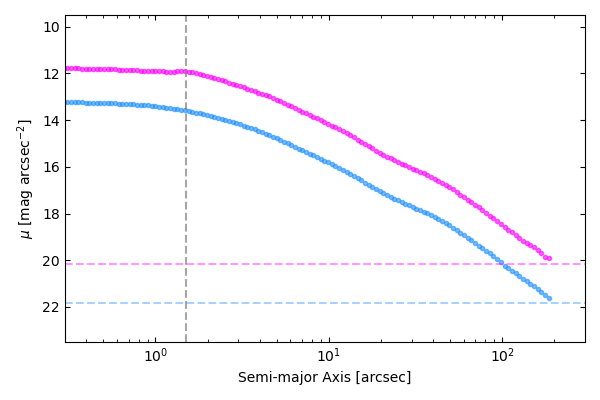

In [14]:
# Unit conversion
r_sma_g = iso_df_g['sma'].values * pixel_scale    # pixel to arcsec
mu_g = mag0_g - 2.5*np.log10(iso_df_g['intens']/sky_val_g) - 2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
r_sma_i = iso_df_i['sma'].values * pixel_scale    # pixel to arcsec
mu_i = mag0_i - 2.5*np.log10(iso_df_i['intens']/sky_val_i) - 2.5*np.log10(pixel_scale**(-2))    # mag/pixel^2 to mag/arcsec^2
### If you already set the mag0 in the unit of 'mag/arcsec^2',
### then you do not have to convert the unit from 'mag/pixel^2' to 'mag/arcsec^2'!

# Plotting
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(r_sma_g, mu_g, 'o', ms=3.0, color='dodgerblue', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.plot(r_sma_i, mu_i, 'o', ms=3.0, color='magenta', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.axhline(mag0_g - 2.5*np.log10(pixel_scale**(-2)), 0, 1,
           linestyle='--', color='dodgerblue', linewidth=1.5, alpha=0.4)
ax.axhline(mag0_i - 2.5*np.log10(pixel_scale**(-2)), 0, 1,
           linestyle='--', color='magenta', linewidth=1.5, alpha=0.4)
ax.axvline(1.5, 0, 1, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)
ax.set_xlim([0.3, 300])
ax.set_xscale('log')
ax.set_ylim([23.5, 9.5])
ax.set_xlabel("Semi-major Axis [arcsec]")
ax.set_ylabel(r"$\mu$ [mag ${\rm arcsec^{-2}}$]")
plt.tight_layout()

### 3) Sersic Profile Fitting

In [15]:
from scipy.optimize import curve_fit

#### Sersic profile (Useful reference: [Graham & Driver 2005](https://ui.adsabs.harvard.edu/abs/2005PASA...22..118G/abstract))

$\large \mu(R)=\mu_{e}+\frac{2.5b_{n}}{\rm ln(10)}\left[(R/R_{e})^{1/n}-1\right]$

where $b_{n}=2n-1/3$

In [16]:
def sersic(r, mu_e, re, n):
    bn = 2 * n - 1/3
    return mu_e + (2.5 * bn / np.log(10)) * ((r / re)**(1/n) - 1)

In [17]:
# Fitting range except r < 1.5 arcsec (Seeing effect)

print("\n*** g-band ***")
popt_g, pcov_g = curve_fit(sersic, r_sma_g[r_sma_g > 1.5], mu_g[r_sma_g > 1.5])
perr_g = np.sqrt(np.diag(pcov_g))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_g[1], perr_g[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_g[0], perr_g[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_g[2], perr_g[2]))

print("\n*** i-band ***")
popt_i, pcov_i = curve_fit(sersic, r_sma_i[r_sma_i > 1.5], mu_i[r_sma_i > 1.5])
perr_i = np.sqrt(np.diag(pcov_i))
print("Effective radius: {0:.2f} +/- {1:.2f} arcsec".format(popt_i[1], perr_i[1]))
print("Surface brightness at effective radius: {0:.2f} +/- {1:.2f} mag/arcsec^2".format(popt_i[0], perr_i[0]))
print("Sersic index: {0:.2f} +/- {1:.2f}".format(popt_i[2], perr_i[2]))


*** g-band ***
Effective radius: 64.54 +/- 2.45 arcsec
Surface brightness at effective radius: 19.15 +/- 0.08 mag/arcsec^2
Sersic index: 5.46 +/- 0.15

*** i-band ***
Effective radius: 65.73 +/- 2.34 arcsec
Surface brightness at effective radius: 17.55 +/- 0.07 mag/arcsec^2
Sersic index: 5.59 +/- 0.14


<IPython.core.display.Javascript object>


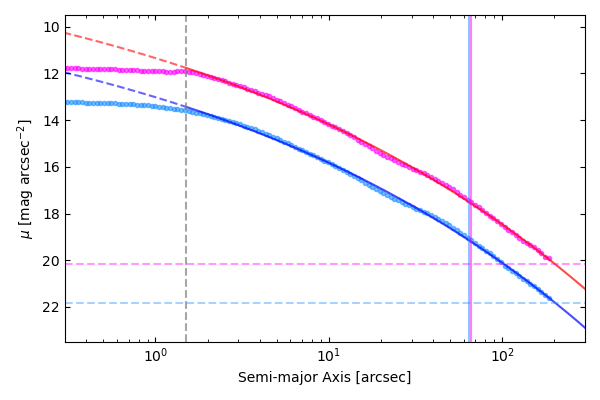

In [18]:
# Plotting for check
r_array = np.logspace(-1.0, 3.0, 1000)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(r_sma_g, mu_g, 'o', ms=3.0, color='dodgerblue', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.plot(r_array[r_array <= 1.5], sersic(r_array[r_array <= 1.5], *popt_g), '--', color='blue', alpha=0.6)
ax.plot(r_array[r_array > 1.5] , sersic(r_array[r_array > 1.5], *popt_g) , '-', color='blue', alpha=0.7)
ax.plot(r_sma_i, mu_i, 'o', ms=3.0, color='magenta', alpha=0.6)#, linewidth=2.0, alpha=0.9)
ax.plot(r_array[r_array <= 1.5], sersic(r_array[r_array <= 1.5], *popt_i), '--', color='red', alpha=0.6)
ax.plot(r_array[r_array > 1.5] , sersic(r_array[r_array > 1.5], *popt_i) , '-', color='red', alpha=0.7)
# ax.plot([popt[1], popt[1]], [18,10], '--', color='gray', alpha=0.7)
ax.axhline(mag0_g - 2.5*np.log10(pixel_scale**(-2)), 0, 1,
           linestyle='--', color='dodgerblue', linewidth=1.5, alpha=0.4)
ax.axhline(mag0_i - 2.5*np.log10(pixel_scale**(-2)), 0, 1,
           linestyle='--', color='magenta', linewidth=1.5, alpha=0.4)
ax.axvline(1.5, 0, 1, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)
ax.axvline(popt_g[1], 0, 1, linestyle='-', color='dodgerblue', linewidth=1.5, alpha=0.5)
ax.axvline(popt_i[1], 0, 1, linestyle='-', color='magenta', linewidth=1.5, alpha=0.5)
ax.set_xlim([0.3, 300])
ax.set_xscale('log')
ax.set_ylim([23.5, 9.5])
ax.set_xlabel("Semi-major Axis [arcsec]")
ax.set_ylabel(r"$\mu$ [mag ${\rm arcsec^{-2}}$]")
plt.tight_layout()

# 4. Surface Photometry Example #2 (Spiral, M100)

### 1) $g$-band

### 2) $i$-band

### 3) Results

### 4) Sersic Profile Fitting